In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

In [2]:
class function:
    def __init__(self, dim, value, grad, hessian):
        self.dim = dim
        self.value = value
        self.grad = grad
        self.hessian = hessian

In [3]:
class probleme:
    def __init__(self, f):
        self.f = f
        
    def __call__(self, x):
        return self.f.value(x)

In [4]:
f_d = {
    "dim": 1,
    "value": lambda x, gamma=1: gamma*x[0]**2 - 5 * x[0] + 3,
    "grad": lambda x, gamma=1: np.array([2*x[0]*gamma - 5]),
    "hessian": lambda x, gamma=1: np.diag([2*gamma])
}
f_1 = function(**f_d)
P = probleme(f_1)

In [5]:
f_2_d = {
    "dim": 2,
    "value": lambda x, gamma=1: x[0]**2 + gamma*x[1]**2,
    "grad": lambda x, gamma=1: np.array([2*x[0], 2*gamma*x[1]]),
    "hessian": lambda x, gamma=1: np.diag([2, 2*gamma])
}

f_2 = function(**f_2_d)

# Méthode de Newton

In [6]:
def backtracking(f, x, alpha=0.1, beta=0.8):
    t = 1
    desc_d = -1 * f.grad(x)
    while f.value(x + desc_d * t) > f.value(x) + alpha * t * np.dot(f.grad(x).T, desc_d):
        t = beta * t
    return t, desc_d

In [7]:
def constant(*args):
    return 0.01

In [8]:
class Newton:
    def __init__(self, f, pas, epsilon=0.01):
        self.epsilon = epsilon
        self.f = f
        self.pas = pas
        self.save = np.array([])
        self.dirs = np.array([])
        
    def __call__(self, x0):
        self.save = []
        self.dirs = []
        x = x0
        self.save.append(x)
        dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
        lmd = -1 * np.dot(self.f.grad(x).T, dxN)
        while lmd / 2 > self.epsilon:
            dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
            lmd = -1 * np.dot(self.f.grad(x).T, dxN)
            (t, dire) = self.pas(self.f, x)
            self.dirs.append(dire)
            x = x + t * dxN
            self.save.append(x)
        self.save = np.array(self.save)
        self.dirs = np.array(self.dirs)
        return x
    
    def plot(self):
        if self.save.shape[0] == 0:
            raise Exception("The Newton method algorithm has not been run")
        if self.f.dim == 1:
            plt.figure(figsize=(15, 15))
            x = np.linspace(-1 * self.save.max() - 5, self.save.max() + 5, 1000).reshape((1, -1))
            plt.plot(x.reshape((-1)), self.f.value(x))
            plt.scatter(self.save[:, 0], self.f.value(self.save[:, 0].reshape(1, -1)), 50, c="red")
            plt.grid()
            plt.show()
        elif self.f.dim == 2:
            plt.figure(figsize=(15, 15))
            x, y = np.linspace(-1 * self.save[:, 0].max() - 5, self.save[:, 0].max() + 5, 200), np.linspace(- 1 * self.save[:, 1].max() - 5, self.save[:, 1].max() + 5, 200)
            X, Y = np.meshgrid(x, y)
            x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(2, -1)
            plt.contour(X, Y, self.f.value(x_y).reshape(200, -1), 15)
            plt.scatter(self.save[:, 0], self.save[:, 1], 50, c="red")
            plt.grid()
            plt.show()
        else:
            raise Exception("Dimension > 2 not implemented")

In [9]:
meth = Newton(f_1, backtracking)
meth(np.array([100]))
print(meth.dirs)

[[-1.95e+02]
 [-3.90e+01]
 [-7.80e+00]
 [-1.56e+00]
 [-3.12e-01]
 [-6.24e-02]]


# Descente de Gradient

In [10]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        #x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        return (x, iters, iters_dir, n_iter)

In [11]:
GD_default = GD()

In [12]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : f_1.value ([x])),
                                             (lambda x, f, tol : f_1.grad(x)), True)

 Iteration nu. = 818
 approx. = [2.5000005]
 ob value = [-3.25]
 and decay = 9.977487120949036e-07.


In [13]:
newt = Newton(f_1, backtracking)
newt(np.array([10]))
print(newt.dirs)

[[-15.  ]
 [ -3.  ]
 [ -0.6 ]
 [ -0.12]]


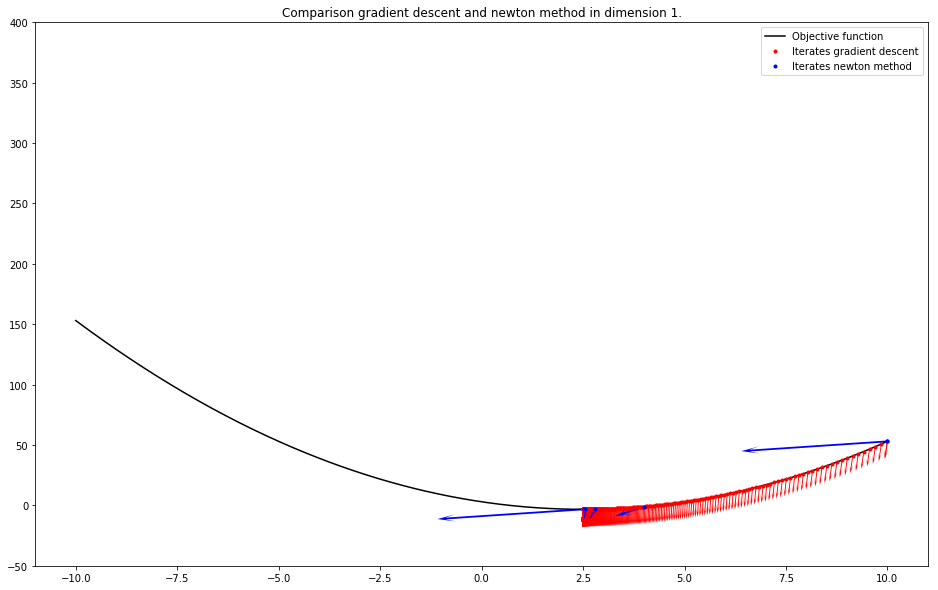

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: f_1.value(x.reshape(1, -1))
x = np.linspace(-10, 10, 600)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
# reshaping iters for input
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates gradient descent")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.001, headwidth=4, headlength=10)

ax.plot(newt.save, f(newt.save), 'b.', label="Iterates newton method")
ax.quiver(newt.save, f(newt.save), newt.dirs, -1, 
          color='b', scale=None, width=0.002, headwidth=4, headlength=10)

ax.set_title("Comparison gradient descent and newton method in dimension 1.")
ax.legend()
print()

# Descente de Gradient avec Backtracking

In [15]:
class backtrackingC():
    
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        
    def __call__(self, x, f, dir_x, grad, n_iter, eta, tol=1e-6):
        n_while = 0
        t = 1
        #x = x.reshape(1, -1)
        grad_f = grad(x, f, tol)
        while f(x + t * dir_x) > f(x) + self.alpha * t * grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta * t
            n_while += 1
        return t

In [16]:
bt_rate = backtrackingC()

In [17]:
gammas = np.linspace(1, 10, 10)
gammas

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [18]:
init_pt = np.array([1])

In [19]:
def dsgd(x, f, grad, tol):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    grad_f = grad(x, f, tol)
    abs_grad = np.abs(grad_f)
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = grad_f[0, imax_diff]
    return (- sdescent)

In [20]:
GD_ri_bt = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter"])
GD_list_bt = {}
for gamma in gammas:
    GD_list_bt["quadra"] = GD(rate = bt_rate)
    opt_pt, _, _, n_iter = GD_list_bt["quadra"](init_pt, 
                                                       (lambda x: f_1.value (x, gamma)), 
                                                       (lambda x, f, tol : f_1.grad(x, gamma)))
    naming_format = "{}_{}".format("quadra", gamma)
    GD_ri_bt.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                              "rate" : "backtracking",
                                              "optimal_pt": opt_pt,
                                              "optimal_val": f_1.value(opt_pt, gamma),
                                              "nb_iter": n_iter })
GD_ri_bt

,gamma,rate,optimal_pt,optimal_val,nb_iter
quadra_1.0,1.0,backtracking,[2.4999996683891204],-3.250000,30
quadra_2.0,2.0,backtracking,[1.2500002268920283],-0.125000,31
quadra_3.0,3.0,backtracking,[0.8333331703668186],0.916667,401
quadra_4.0,4.0,backtracking,[0.6249999033875625],1.437500,39
quadra_5.0,5.0,backtracking,[0.500000087301781],1.750000,40
quadra_6.0,6.0,backtracking,[0.4166667480291629],1.958333,32
quadra_7.0,7.0,backtracking,[0.35714279262200394],2.107143,125
quadra_8.0,8.0,backtracking,[0.3124999387673933],2.218750,49
quadra_9.0,9.0,backtracking,[0.2777778304588404],2.305556,236
quadra_10.0,10.0,backtracking,[0.25000004796095704],2.375000,50


In [21]:
init_pt_d2 = np.array([2, 2])

In [22]:
init_pt_d2

array([2, 2])

In [23]:
GD_ri_2 = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter", "iters", "iters_dir"])
GD_list_2 = {}
for gamma in gammas:
    GD_list_2["quadra"] = GD(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.1)
    opt_pt, iters, iters_dir, n_iter = GD_list_2["quadra"](init_pt_d2, 
                                                 (lambda x: f_2.value (x, gamma)), 
                                                 (lambda x, f, tol : f_2.grad(x, gamma)))
    naming_format = "{}_{}".format("quadra", gamma)
    GD_ri_2.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                             "rate" : 0.01,
                                             "optimal_pt": opt_pt,
                                             "optimal_val": f_2.value(opt_pt, gamma),
                                             "nb_iter": n_iter,
                                             "iters": iters,
                                             "iters_dir": iters_dir})
GD_ri_2.loc[:, "gamma": "nb_iter"]

/home/heldhy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Decay didn't get under tolerance rate.


,gamma,rate,optimal_pt,optimal_val,nb_iter
quadra_1.0,1.0,0.01,"[3.2910091146424137e-07, 3.2910091146424137e-07]",2.166148e-13,70
quadra_2.0,2.0,0.01,"[4.113761393303017e-07, 9.85068138182558e-16]",1.692303e-13,69
quadra_3.0,3.0,0.01,"[4.113761393303017e-07, 6.968982874540769e-28]",1.692303e-13,69
quadra_4.0,4.0,0.01,"[4.113761393303017e-07, 1.1805916207173949e-48]",1.692303e-13,69
quadra_5.0,5.0,0.01,"[4.113761393303017e-07, 0.0]",1.692303e-13,69
quadra_6.0,6.0,0.01,"[4.113761393303017e-07, -1.180591620717441e-48]",1.692303e-13,69
quadra_7.0,7.0,0.01,"[4.113761393303017e-07, -6.968982874540931e-28]",1.692303e-13,69
quadra_8.0,8.0,0.01,"[4.113761393303017e-07, -9.850681381825706e-16]",1.692303e-13,69
quadra_9.0,9.0,0.01,"[5.521397077432454e-08, 5.5213970774325126e-08]",3.048583e-14,78
quadra_10.0,10.0,0.01,"[2.4604638443222403e-97, 2.0]",4.000000e+01,1000


In [27]:
f_2.value(x_y)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [35]:
x_y

[[2], [2]]

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

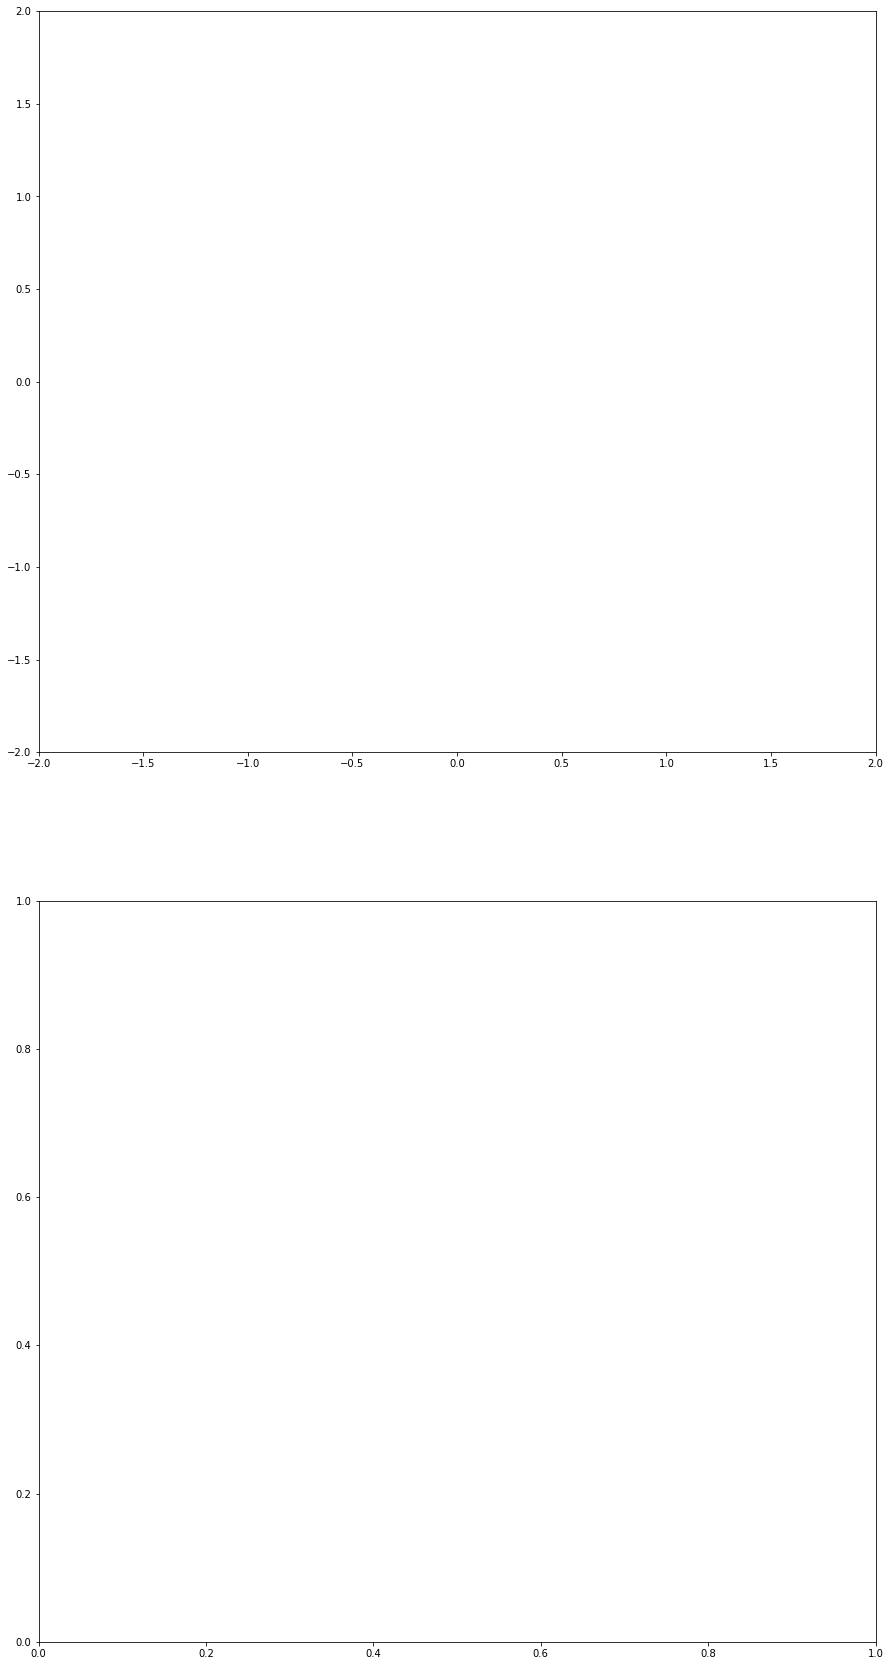

In [34]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
x_y = [[2],[2]]
## Plotting level curves for extreme cases
extreme_cases = [gammas[0], gammas[-1]]
for i in range(len(extreme_cases)):
    ax[i].set_xlim(x_mi, x_ma)
    ax[i].set_ylim(y_mi, y_ma)
    ax[i].contour(X, Y, f_2.value(x_y, gammas[i]).reshape(nb_pts, -1), 15)
    ax[i].quiver(GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 0], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 1],
                 color='b', scale=6, width=0.002, headwidth=4, headlength=5)
    ax[i].plot(GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
               GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1],
               'b.')